In [29]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split




In [30]:
df = pd.read_csv('dataset.csv')
print(df.head())  

                           id  year  month  day  hour  minute  press  humid  \
0         2021-09-16 18:00:00  2021      9   16    18       0   1012     78   
1  2021-09-16 18:10:00.000004  2021      9   16    18      10   1012     78   
2  2021-09-16 18:19:59.999999  2021      9   16    18      19   1012     78   
3  2021-09-16 18:30:00.000003  2021      9   16    18      30   1012     79   
4  2021-09-16 18:39:59.999998  2021      9   16    18      39   1012     79   

   temp  ws40  ...  vertdisp140  vertdisp150  vertdisp160  vertdisp170  \
0  27.6  7.44  ...         0.44         0.44         0.44         0.45   
1  27.5  7.45  ...         0.48         0.50         0.51         0.53   
2  27.5  7.59  ...         0.33         0.35         0.37         0.38   
3  27.5  7.64  ...         0.47         0.46         0.47         0.48   
4  27.4  9.06  ...         0.38         0.38         0.36         0.35   

   vertdisp180  vertdisp190  vertdisp200  vertdisp220  vertdisp240  \
0         

In [31]:
df.index = pd.to_datetime(df['id'], errors='ignore')
df.index = df['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))

C:\Users\lucas\AppData\Local\Temp\ipykernel_16852\2288332652.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.index = pd.to_datetime(df['id'], errors='ignore')
C:\Users\lucas\AppData\Local\Temp\ipykernel_16852\2288332652.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.index = df['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))


In [32]:

cols = list(df)[1:9]
cols += ["ws100", "verts100", "wdir100", "cis10", "wdisp100", "vertdisp100"]


cols

['year',
 'month',
 'day',
 'hour',
 'minute',
 'press',
 'humid',
 'temp',
 'ws100',
 'verts100',
 'wdir100',
 'cis10',
 'wdisp100',
 'vertdisp100']

In [33]:
df_for_training = df[cols].astype(float)

df_for_training

,year,month,day,hour,minute,press,humid,temp,ws100,verts100,wdir100,cis10,wdisp100,vertdisp100
id,,,,,,,,,,,,,,
2021-09-16 18:00:00,2021.0,9.0,16.0,18.0,0.0,1012.0,78.0,27.6,8.51,0.01,53.95,0.004,1.16,0.47
2021-09-16 18:10:00,2021.0,9.0,16.0,18.0,10.0,1012.0,78.0,27.5,8.64,0.01,52.19,0.008,1.04,0.50
2021-09-16 18:19:59,2021.0,9.0,16.0,18.0,19.0,1012.0,78.0,27.5,8.65,-0.07,52.02,0.006,1.04,0.35
2021-09-16 18:30:00,2021.0,9.0,16.0,18.0,30.0,1012.0,79.0,27.5,8.86,-0.11,53.65,0.008,0.96,0.45
2021-09-16 18:39:59,2021.0,9.0,16.0,18.0,39.0,1012.0,79.0,27.4,10.00,0.12,53.49,0.007,0.72,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 13:49:59,2021.0,11.0,8.0,13.0,49.0,1008.0,66.0,30.6,8.36,-0.25,41.55,0.002,1.35,1.00
2021-11-08 14:00:00,2021.0,11.0,8.0,14.0,0.0,1007.0,66.0,30.8,8.62,0.02,37.31,0.000,1.23,0.96
2021-11-08 14:09:59,2021.0,11.0,8.0,14.0,9.0,1007.0,67.0,30.7,8.96,-0.44,37.27,0.000,1.24,1.26


In [34]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


df_for_training_scaled

array([[ 0.        , -1.38571171, -0.0327409 , ..., -0.37055806,
         0.29884617, -0.58901997],
       [ 0.        , -1.38571171, -0.0327409 , ...,  0.19202203,
        -0.05423555, -0.48923104],
       [ 0.        , -1.38571171, -0.0327409 , ..., -0.08926801,
        -0.05423555, -0.9881757 ],
       ...,
       [ 0.        ,  1.78444449, -0.89379809, ..., -0.93313814,
         0.53423398,  2.03875522],
       [ 0.        ,  1.78444449, -0.89379809, ..., -0.79249312,
         0.41654007,  1.24044377],
       [ 0.        ,  1.78444449, -0.89379809, ..., -0.6518481 ,
        -0.05423555,  0.87455102]])

In [35]:
sequence_length = 36  
n_features = df_for_training_scaled.shape[1] 

In [36]:
X, y = [], []

for i in range(len(df_for_training_scaled) - sequence_length):
    X.append(df_for_training_scaled[i:i + sequence_length])
    y.append(df_for_training_scaled[i + sequence_length, cols.index("ws100")])

X = np.array(X)
y = np.array(y)

print(f"Formato de X: {X.shape}")  
print(f"Formato de y: {y.shape}")  

Formato de X: (7525, 36, 14)
Formato de y: (7525,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (6020, 36, 14), X_test: (1505, 36, 14)
y_train: (6020,), y_test: (1505,)


In [38]:
model = Sequential()

model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


c:\Users\lucas\Projetos\TFG_VENTO_SUL\TFG-Vento-Sul\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.3894 - val_loss: 0.1696
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.1678 - val_loss: 0.1561
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.1517 - val_loss: 0.1283
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1567 - val_loss: 0.1157
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1443 - val_loss: 0.1332
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1308 - val_loss: 0.1416
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.1329 - val_loss: 0.1184
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 3.6601 - val_loss: 0.1321
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.1399 - val_loss: 0.1157
Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1399 - val_loss: 0.1204
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.1340 - val_loss: 0.1106
Epoch 12/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/ste

In [39]:
y_pred = model.predict(X_test)

print(f"Formato de y_pred: {y_pred.shape}")

y_test_orig = scaler.inverse_transform(
    np.hstack((np.zeros((len(y_test), X_train.shape[2] - 1)), y_test.reshape(-1, 1)))
)[:, -1]  

y_pred_orig = scaler.inverse_transform(
    np.hstack((np.zeros((len(y_pred), X_train.shape[2] - 1)), y_pred))
)[:, -1]

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Formato de y_pred: (1505, 1)


[Timestamp('2021-11-08 08:40:00'), Timestamp('2021-11-09 08:40:00'), Timestamp('2021-11-10 08:40:00'), Timestamp('2021-11-12 08:40:00'), Timestamp('2021-11-15 08:40:00'), Timestamp('2021-11-16 08:40:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


KeyError: "None of [Index(['Date', 'Open'], dtype='object')] are in the [columns]"

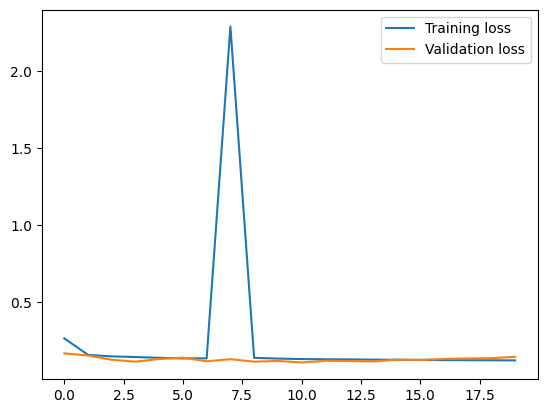

In [41]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

 
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 36
n_days_for_prediction=6  

predict_period_dates = pd.date_range(list(df.index)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

prediction = model.predict(X_train[-n_days_for_prediction:]) 


prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

MSE: 0.013341553485014302


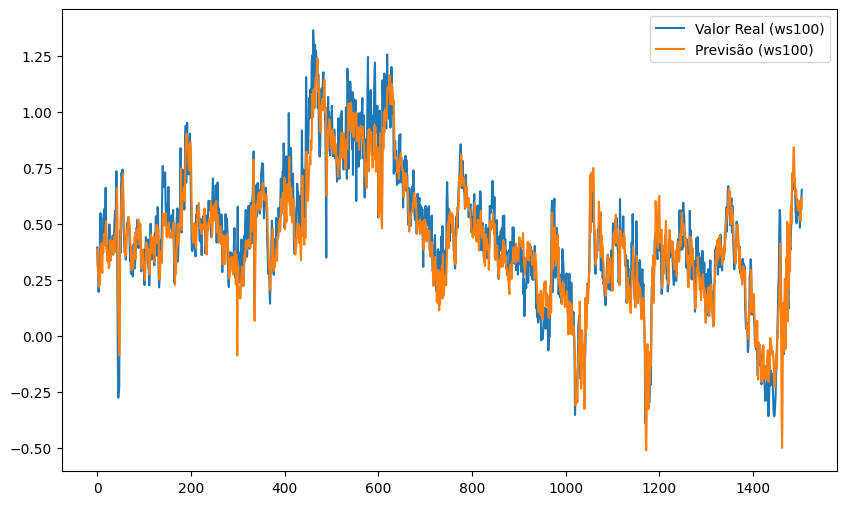

In [42]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mse = mean_squared_error(y_test_orig, y_pred_orig)
print(f"MSE: {mse}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_orig, label='Valor Real (ws100)')
plt.plot(y_pred_orig, label='Previsão (ws100)')
plt.legend()
plt.show()